# 03-201 : Unbalanced Per Question

Before trying to balance the data, experiment with creating models per question which was not done in the previous notebook.

## Web References


In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import sys
import logging
import pandas as pd

from competition import source_data as sd
from competition import data_preparation as dp
from competition import feature_engineering as fe

import seaborn as sns
import matplotlib.pyplot as plt

### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-27 06:37:39 INFO     Started


## Data Collection

In [4]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [6]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source,
                                    elapsed_time_min_clip=0,
                                    elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [7]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Exploratory Data Analysis

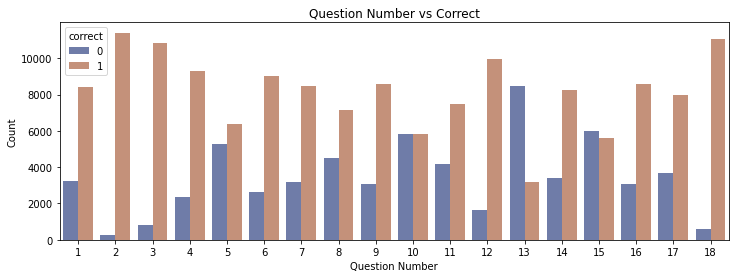

In [8]:
plt.figure(figsize=(12, 4))
g = sns.countplot(
    data=df_source_labels,
    x='question_num',
    hue='correct',
    palette='dark',
    alpha=.6)

g.set_xlabel('Question Number')
g.set_ylabel('Count')
g.set_title('Question Number vs Correct')

plt.show()

## Feature Engineering

In [11]:
# create the initial features
df_features = fe.create_initial_features(df_source, df_source_labels)

In [12]:
# add the feature to the features dataset
df_features = fe.add_elapsed_time_features(
    features=df_features,
    X=df_source)

In [13]:
# add the total count features to the features dataset
df_features = fe.add_count_total_features(
    features=df_features,
    X=df_source)

In [14]:
# add the unique count features to the features dataset
df_features = fe.add_count_unique_features(
    features=df_features,
    X=df_source)

In [15]:
with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.000000,0.203390,0.090909,0.225
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320,0.394721,0.394721,0.402262,0.394721,0.480127,0.75,0.000000,0.525424,0.545455,0.675
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002,0.245951,0.245951,0.276252,0.245951,0.257552,0.75,0.000000,0.355932,0.454545,0.400
3,20090312433251036,0-4,0.001352,0.063074,0.000000,0.026311,0.000000,0.057588,0.057588,0.053312,0.057588,0.050874,1.00,0.333333,0.067797,0.000000,0.075
4,20090312433251036,13-22,0.324157,1.000000,0.318718,0.676403,1.000000,1.000000,1.000000,1.000000,1.000000,0.585056,1.00,1.000000,0.932203,0.909091,0.875
5,20090312433251036,5-12,0.021933,0.221287,0.072301,0.150206,0.072301,0.364727,0.364727,0.400646,0.364727,0.238474,1.00,0.333333,0.457627,0.454545,0.350


## Data Selection